In [1]:
import torch
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from tqdm import tqdm
from accelerate import Accelerator
import torch.optim as optim
import torch.nn.functional as F

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
])

train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


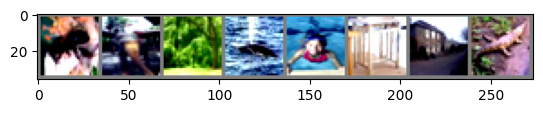

In [3]:
def imshow(img):
    img = img / 2 + 0.5  # денормализация
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    
train_iter = iter(train_loader)
imshow(utils.make_grid(next(train_iter)[0][:8]))
# train_dataset[0][0].shape

In [4]:
class VQ(nn.Module):
    
    def __init__(self,num_embeddings=512,embedding_dim=64,commitment_cost=0.25):
        super().__init__()

        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost
        
        self.embeddings = nn.Embedding(self.num_embeddings,self.embedding_dim)
        self.embeddings.weight.data.uniform_(-1/self.num_embeddings,1/self.num_embeddings)
    
    def forward(self,inputs):
        inputs = inputs.permute(0,2,3,1).contiguous()
        input_shape = inputs.shape
        
        flat_inputs = inputs.view(-1,self.embedding_dim)
        
        distances = torch.cdist(flat_inputs,self.embeddings.weight)
        encoding_index = torch.argmin(distances,dim=1) 
        
        quantized = torch.index_select(self.embeddings.weight,0,encoding_index).view(input_shape)
        
        e_latent_loss = F.mse_loss(quantized.detach(),inputs)
        q_latent_loss = F.mse_loss(quantized,inputs.detach())
        c_loss = q_latent_loss + self.commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        
        quantized = quantized.permute(0,3,1,2).contiguous()
        return c_loss, quantized

In [5]:
class ResudialBlock(nn.Module):
    def __init__(self,in_channels,out_channels,hidden_channels):
        super(ResudialBlock,self).__init__()
        self.resblock = nn.Sequential(nn.ReLU(inplace=True),
                                       nn.Conv2d(in_channels,hidden_channels,kernel_size=3,stride=1,padding=1,bias=False),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(hidden_channels,out_channels,kernel_size=1,stride=1,bias=False))
    def forward(self,x):
        return x + self.resblock(x)

class ResudialStack(nn.Module):
    def __init__(self,in_channels,out_channels,hidden_channels,num_res_layers):
        super(ResudialStack,self).__init__()
        self.num_res_layers = num_res_layers
        self.layers = nn.ModuleList([ResudialBlock(in_channels,out_channels,hidden_channels) for _ in range(num_res_layers)])
    
    def forward(self,x):
        for i in range(self.num_res_layers):
            x = self.layers[i](x)
        return F.relu(x)

In [6]:
class Model(nn.Module):

    def __init__(self,num_embeddings=512,embedding_dim=64,commitment_cost=0.25):
        super().__init__()

        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost

        #encode
        self.conv1 = nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1)
        self.conv2 = nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1)
        self.conv3 = nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1)
        self.resblock1 = ResudialStack(128,128,64,3)
        
        #vq 
        self.vq_conv = nn.Conv2d(128,self.embedding_dim,kernel_size=1,stride=1)
        self.vq = VQ(self.num_embeddings,self.embedding_dim,self.commitment_cost)
        
        #decode
        self.conv4 = nn.Conv2d(self.embedding_dim,64,kernel_size=3,stride=1,padding=1)
        self.resblock2 = ResudialStack(64,64,32,3)
        self.conv5 = nn.ConvTranspose2d(64,32,kernel_size=4,stride=2,padding=1)
        self.conv6 = nn.ConvTranspose2d(32,3,kernel_size=4,stride=2,padding=1)


    def encode(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        x = self.resblock1(x)
        return x
        
    def decode(self,quantized):
        x = self.conv4(quantized)
        x = self.resblock2(x)
        x = F.relu(self.conv5(x))
        x = self.conv6(x)
        return x

    def forward(self,inputs):
        x = self.encode(inputs)
        c_loss,quantized =  self.vq(self.vq_conv(x))
        outputs = self.decode(quantized)
        rec_loss = F.mse_loss(outputs,inputs)
        loss = rec_loss + c_loss
        return loss,outputs,rec_loss

In [7]:
def test(model,test_loader):
    model.eval()
    test_loss = 0
    rec_loss = 0
    with torch.no_grad():
        for i, inputs in enumerate(test_loader):
            loss,_,loss2 = model(inputs)
            test_loss += loss.item()
            rec_loss += loss2.item()

    test_loss /= len(test_loader)
    rec_loss /= len(test_loader)
    return test_loss,rec_loss

def evaluate(model,valid_loader):
    model.eval()
    valid_loss = 0
    rec_loss = 0
    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader):
            loss,_,loss2 = model(inputs)
            valid_loss += loss.item()
            rec_loss += loss2.item()

    valid_loss /= len(valid_loader)
    rec_loss /= len(valid_loader)
    return valid_loss,rec_loss

def train(train_loader,valid_loader,model,optimizer, num_epochs=50, lr_scheduler=None):
    best_loss = 9999999
    for ep in range(num_epochs):
        train_loss = 0
        for inputs, labels in tqdm(train_loader):
            optimizer.zero_grad()
            model.train()
            loss,_,_ = model(inputs)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            if lr_scheduler:
                lr_scheduler.step()

        train_loss /= len(train_loader)
        valid_loss,rec_loss = evaluate(model,valid_loader) 

        print(f"Epoch:{ep} |Train Loss:{train_loss}|Valid Loss:{valid_loss}|Rec Loss:{rec_loss}")
        
        test_iter = iter(test_loader)
        cur_iter = next(test_iter)
        if ep % 10 == 0:
            print('True:')
            imshow(utils.make_grid(cur_iter[0][:4].cpu(), nrow=4))       
            print('Reconstruct:')
            imshow(utils.make_grid(model(cur_iter[0][:4])[1].cpu(), nrow=4))

        if rec_loss <= best_loss:
            best_loss = rec_loss
            torch.save(model.state_dict(),'./vq_vae_model.pt')

100%|██████████| 157/157 [00:01<00:00, 83.55it/s]

Epoch:0 |Train Loss:17.539408226718987|Valid Loss:0.6234870131608028|Rec Loss:0.20502650310659104


True:


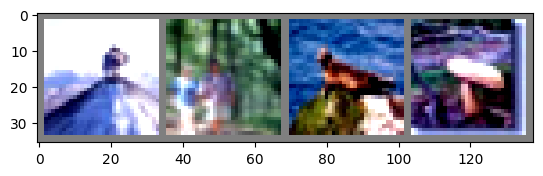

Reconstruct:


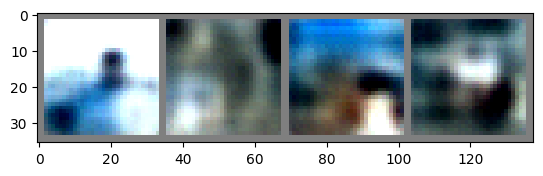

100%|██████████| 157/157 [00:01<00:00, 91.56it/s]

Epoch:1 |Train Loss:0.34539746763684864|Valid Loss:0.234854142377331|Rec Loss:0.14456402216177838



100%|██████████| 157/157 [00:01<00:00, 91.11it/s]

Epoch:2 |Train Loss:0.2002832259401641|Valid Loss:0.18391059301081736|Rec Loss:0.11261362653629035



100%|██████████| 157/157 [00:01<00:00, 87.59it/s]


Epoch:3 |Train Loss:0.16599160656714074|Valid Loss:0.15686686764097518|Rec Loss:0.09369755792579833


100%|██████████| 157/157 [00:01<00:00, 85.87it/s]

Epoch:4 |Train Loss:0.14909429388963963|Valid Loss:0.14717153996039348|Rec Loss:0.08550290649483917



100%|██████████| 157/157 [00:01<00:00, 88.36it/s]


Epoch:5 |Train Loss:0.14013499959998424|Valid Loss:0.1394889679304354|Rec Loss:0.08028230692740458


100%|██████████| 157/157 [00:01<00:00, 91.98it/s]

Epoch:6 |Train Loss:0.13059871126433162|Valid Loss:0.13054362589576443|Rec Loss:0.07620554047215516



100%|██████████| 157/157 [00:01<00:00, 90.89it/s]

Epoch:7 |Train Loss:0.12606422383995616|Valid Loss:0.1277926330258892|Rec Loss:0.07013819506688482



100%|██████████| 157/157 [00:01<00:00, 93.45it/s] 

Epoch:8 |Train Loss:0.12333917258607457|Valid Loss:0.12556699516287276|Rec Loss:0.06948499426625337



100%|██████████| 157/157 [00:01<00:00, 78.70it/s]


Epoch:9 |Train Loss:0.12049730975762048|Valid Loss:0.12380208976709159|Rec Loss:0.06933719956666042


100%|██████████| 157/157 [00:01<00:00, 89.07it/s]

Epoch:10 |Train Loss:0.11877173443546381|Valid Loss:0.12088410556316376|Rec Loss:0.06762184195552662


True:


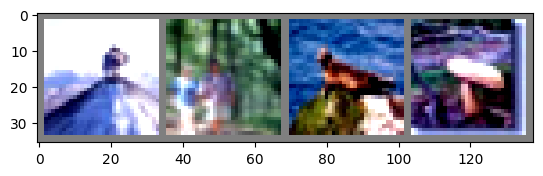

Reconstruct:


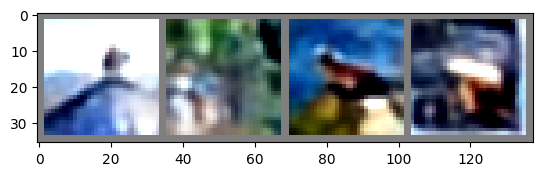

100%|██████████| 157/157 [00:01<00:00, 93.09it/s] 


Epoch:11 |Train Loss:0.11793970567224275|Valid Loss:0.1202523243749977|Rec Loss:0.06284383501691423


100%|██████████| 157/157 [00:01<00:00, 92.86it/s]


Epoch:12 |Train Loss:0.12481156223074859|Valid Loss:0.13185380323297657|Rec Loss:0.06258327136658559


100%|██████████| 157/157 [00:01<00:00, 83.13it/s]

Epoch:13 |Train Loss:0.13248755636117648|Valid Loss:0.13281987412909793|Rec Loss:0.05934842481354999



100%|██████████| 157/157 [00:01<00:00, 86.83it/s]

Epoch:14 |Train Loss:0.1336063675086974|Valid Loss:0.13793592050576667|Rec Loss:0.05708558067299758



100%|██████████| 157/157 [00:01<00:00, 86.32it/s]

Epoch:15 |Train Loss:0.13346536902477368|Valid Loss:0.13341269219756885|Rec Loss:0.05601961056517947



100%|██████████| 157/157 [00:01<00:00, 89.37it/s]

Epoch:16 |Train Loss:0.13297437174279061|Valid Loss:0.13641096955272042|Rec Loss:0.05645909736965113



100%|██████████| 157/157 [00:01<00:00, 87.20it/s]

Epoch:17 |Train Loss:0.13213192337118757|Valid Loss:0.13221780476486608|Rec Loss:0.054605568954899056



100%|██████████| 157/157 [00:01<00:00, 88.27it/s]


Epoch:18 |Train Loss:0.13221337597655214|Valid Loss:0.1350403322725539|Rec Loss:0.05508004684167303


100%|██████████| 157/157 [00:01<00:00, 91.70it/s] 

Epoch:19 |Train Loss:0.1325200324892388|Valid Loss:0.1348530299914111|Rec Loss:0.05325369944997654



100%|██████████| 157/157 [00:01<00:00, 83.10it/s]

Epoch:20 |Train Loss:0.1332753202913667|Valid Loss:0.13735543224652103|Rec Loss:0.05266127550298241


True:


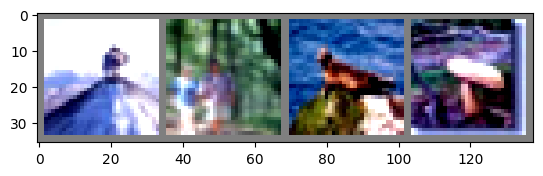

Reconstruct:


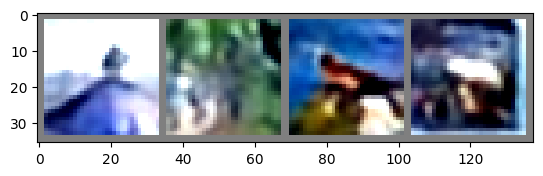

100%|██████████| 157/157 [00:01<00:00, 85.34it/s]

Epoch:21 |Train Loss:0.13498091892055844|Valid Loss:0.13779951285594588|Rec Loss:0.053117247049216255



100%|██████████| 157/157 [00:01<00:00, 87.97it/s]

Epoch:22 |Train Loss:0.13896484240470336|Valid Loss:0.14329956799365912|Rec Loss:0.05374647745755828



100%|██████████| 157/157 [00:01<00:00, 93.51it/s]


Epoch:23 |Train Loss:0.14205972621660404|Valid Loss:0.15003972144643213|Rec Loss:0.0542310131061229


100%|██████████| 157/157 [00:01<00:00, 89.95it/s]

Epoch:24 |Train Loss:0.14404679621424515|Valid Loss:0.14781437557973678|Rec Loss:0.052284779513527634



100%|██████████| 157/157 [00:01<00:00, 88.12it/s]

Epoch:25 |Train Loss:0.14533579314265715|Valid Loss:0.14768100306866275|Rec Loss:0.05177258322857747



100%|██████████| 157/157 [00:01<00:00, 87.37it/s]

Epoch:26 |Train Loss:0.14590891920354054|Valid Loss:0.14941489506678976|Rec Loss:0.05102418756978527



100%|██████████| 157/157 [00:01<00:00, 87.91it/s]


Epoch:27 |Train Loss:0.1468874893872939|Valid Loss:0.14999247176252353|Rec Loss:0.05057943372684679


100%|██████████| 157/157 [00:01<00:00, 83.31it/s]

Epoch:28 |Train Loss:0.1474664675743531|Valid Loss:0.15206493237975297|Rec Loss:0.05200643438822145



100%|██████████| 157/157 [00:01<00:00, 90.38it/s]

Epoch:29 |Train Loss:0.14791005106685717|Valid Loss:0.15365150381045736|Rec Loss:0.051314130022077804



100%|██████████| 157/157 [00:01<00:00, 89.47it/s]

Epoch:30 |Train Loss:0.14831312025523247|Valid Loss:0.15437389729888576|Rec Loss:0.051975622013875636


True:


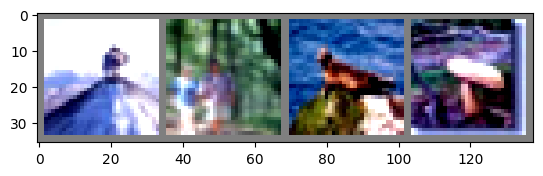

Reconstruct:


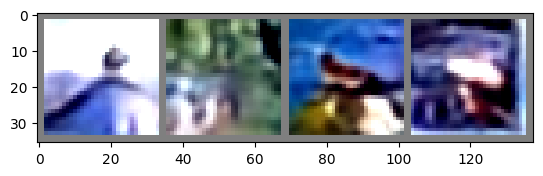

100%|██████████| 157/157 [00:01<00:00, 90.95it/s]

Epoch:31 |Train Loss:0.1487233045956363|Valid Loss:0.1507293138724224|Rec Loss:0.05077402075384833



100%|██████████| 157/157 [00:01<00:00, 87.28it/s]


Epoch:32 |Train Loss:0.14889930748878538|Valid Loss:0.1518730899900388|Rec Loss:0.050167253062983225


100%|██████████| 157/157 [00:01<00:00, 87.36it/s]

Epoch:33 |Train Loss:0.14896294451735514|Valid Loss:0.15232287755437718|Rec Loss:0.05052246905531094



100%|██████████| 157/157 [00:01<00:00, 84.31it/s]

Epoch:34 |Train Loss:0.14898428367569927|Valid Loss:0.15137269096389697|Rec Loss:0.04999629645400746



100%|██████████| 157/157 [00:01<00:00, 91.18it/s]

Epoch:35 |Train Loss:0.14921507666178066|Valid Loss:0.15337865775937487|Rec Loss:0.049595490952206264



100%|██████████| 157/157 [00:01<00:00, 78.55it/s]


Epoch:36 |Train Loss:0.1494331468858987|Valid Loss:0.15078588570379148|Rec Loss:0.04957796623752375


100%|██████████| 157/157 [00:01<00:00, 91.94it/s]

Epoch:37 |Train Loss:0.14956681332205568|Valid Loss:0.15621854099118784|Rec Loss:0.04919386149686613



100%|██████████| 157/157 [00:01<00:00, 84.01it/s]

Epoch:38 |Train Loss:0.14961248065542687|Valid Loss:0.15281886925363236|Rec Loss:0.04926529593148809



100%|██████████| 157/157 [00:01<00:00, 87.44it/s]


Epoch:39 |Train Loss:0.14999203183843046|Valid Loss:0.15200213641877386|Rec Loss:0.04929873594053232


In [8]:
accelerator = Accelerator()
model = Model()
optimizer = optim.Adam(model.parameters(),lr=1e-3)
model,train_loader,test_loader,optimizer = accelerator.prepare(model,train_loader,test_loader,optimizer)
train(train_loader,test_loader,model,optimizer,num_epochs=40,lr_scheduler=None)

In [9]:
accelerator = Accelerator()
model = Model()
model.load_state_dict(torch.load('./vq_vae_model.pt', map_location=torch.device(accelerator.device)))
model.eval();
model,train_loader,test_loader = accelerator.prepare(model,train_loader,test_loader)

In [10]:
activations_encoder = {
    'layer1' : None,
    'layer2' : None,
    'layer3' : None,
    'layer4' : None,
    'layer5': None,
    'layer6': None,
    'layer7': None
}

activations_decoder = {
    'layer1' : None,
    'layer2' : None,
    'layer3' : None,
    'layer4' : None,
    'layer5' : None,
    'layer5' : None,
}
# activations_encoder = {}
def get_activation_foo(name, activations):
    def hookFoo(model, input, output):
        # if activations[name] == None:
        activations[name] = output.detach()
        # else:
        #     activations[name] = torch.cat((activations[name], output.detach()), 0)
    return hookFoo

def get_activation_foo_input(name, activations):
    def hookFoo(model, input, output):
        # if activations[name] == None:
        activations[name] = input[0].detach()
        # else:
        #     activations[name] = torch.cat((activations[name], input[0].detach()), 0)
    return hookFoo

model.conv1.register_forward_hook(get_activation_foo('layer1', activations_encoder))
model.conv2.register_forward_hook(get_activation_foo('layer2', activations_encoder))
model.conv3.register_forward_hook(get_activation_foo('layer3', activations_encoder))
model.resblock1.layers[0].register_forward_hook(get_activation_foo('layer4', activations_encoder))
model.resblock1.layers[1].register_forward_hook(get_activation_foo('layer5', activations_encoder))
model.resblock1.layers[2].register_forward_hook(get_activation_foo('layer6', activations_encoder))
model.vq_conv.register_forward_hook(get_activation_foo('layer7', activations_encoder))

model.conv4.register_forward_hook(get_activation_foo_input('layer1', activations_decoder))
model.resblock2.layers[0].register_forward_hook(get_activation_foo_input('layer2', activations_decoder))
model.resblock2.layers[1].register_forward_hook(get_activation_foo_input('layer3', activations_decoder))
model.resblock2.layers[2].register_forward_hook(get_activation_foo_input('layer4', activations_decoder))
model.conv5.register_forward_hook(get_activation_foo_input('layer5', activations_decoder))
model.conv6.register_forward_hook(get_activation_foo_input('layer6', activations_decoder))

True:


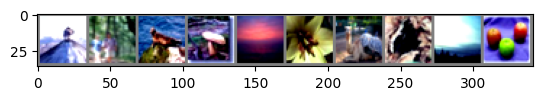

Reconstruct:


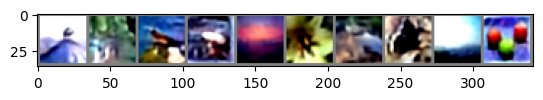

In [11]:
test_iter = iter(test_loader)
cur_iter = next(test_iter)

model.to('cuda')

print('True:')
imshow(utils.make_grid(cur_iter[0][:10].cpu(), nrow=10))       
print('Reconstruct:')
imshow(utils.make_grid(model(cur_iter[0][:10])[1].cpu(), nrow=10))

In [12]:
import sys
sys.path.append('/kaggle/input/smallness/pytorch/smallnet/1')
from smallnet import LinearNet, Net, split_dataset

In [13]:
def transform_to_features(activations, batch_size, device=accelerator.device):
    with torch.no_grad():
        feats = torch.Tensor([]).to(device)
        for key in activations.keys():
            val = activations[key]
            cur_feat = val[-batch_size:]
            if len(val.shape) == 4:
                cur_feat = val[-batch_size:].mean(dim=[2,3])
            feats = torch.cat((feats, cur_feat), dim=1)
            activations[key] = None
        torch.cuda.empty_cache()
    return feats

num_encoder_features = transform_to_features(activations_encoder, 64).shape[1]
num_decoder_features = transform_to_features(activations_decoder, 64).shape[1]
num_all_features = num_encoder_features + num_decoder_features
print(f'num_encoder_features: {num_encoder_features}')
print(f'num_decoder_features: {num_decoder_features}')
print(f'num_all_features: {num_all_features}')

num_encoder_features: 768
num_decoder_features: 352
num_all_features: 1120


In [14]:
def train_model(train_loader, model, criterion, optimizer, model_vae, activations, epochs=90, loss_list=[], device='mps'):
    if activations == 'encoder':
        activations = activations_encoder
    elif activations == 'decoder':
        activations = activations_decoder

    model.train()
    loss_list = []
    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            # print(images.shape)
            with torch.no_grad():
                model_vae(images)
            # print(activations_decoder['layer1'].shape)
            if activations != 'mix':
                features_enc = transform_to_features(activations, labels.shape[0])
            else:
                features_enc = transform_to_features(activations_encoder, labels.shape[0])
                features_dec = transform_to_features(activations_decoder, labels.shape[0])
                features_enc = torch.cat((features_enc, features_dec), dim=1)

            # print(features_enc)
            features_enc = features_enc.to(device)
            outputs = model(features_enc)
            optimizer.zero_grad()

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        loss_list.append(running_loss / len(train_loader))
#         print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")
    return loss_list


def test_model(model, test_loader, model_vae, activations, device='mps'):
    if activations == 'encoder':
        activations = activations_encoder
    elif activations == 'decoder':
        activations = activations_decoder

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            with torch.no_grad():
                model_vae(images)
            if activations != 'mix':
                features_enc = transform_to_features(activations, labels.shape[0])
            else:
                features_enc = transform_to_features(activations_encoder, labels.shape[0])
                features_dec = transform_to_features(activations_decoder, labels.shape[0])
                features_enc = torch.cat((features_enc, features_dec), dim=1)

            features_enc.to(device)

            outputs = model(features_enc)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy}%")
    return accuracy

In [15]:
from torch.utils.data import Subset

def split(dataset, num_train_per_class, num_classes=100):
    train_indices = []
    for i in range(num_classes):
        indices = torch.where(torch.tensor(dataset.targets) == i)[0].tolist()
        train_indices.extend(indices[:num_train_per_class])
    return train_indices

train_indices = split(train_dataset, num_train_per_class=1)

train_subset = Subset(train_dataset, train_indices)
train_sub_loader = DataLoader(train_subset, batch_size=64, shuffle=True)

In [16]:
num_classes = 100

linModel = Net(num_all_features, num_classes).to(accelerator.device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(linModel.parameters(), lr=0.001)

linModel.to(accelerator.device)

train_model(train_sub_loader, linModel, criterion, optimizer, model, activations='mix', epochs=100, loss_list=[], device=accelerator.device);

100%|██████████| 100/100 [00:03<00:00, 30.17it/s]


In [17]:
test_model(linModel, test_loader, model, activations='mix', device=accelerator.device)

Accuracy: 3.19%


3.19

In [21]:
enc_accuracy_diff_size = []
dec_accuracy_diff_size = []
mix_accuracy_diff_size = []

num_classes = 100


for train_size in [2, 4, 8, 16, 32, 64, 128, 256, 512,1024]:
    train_indices = split(train_dataset, num_train_per_class=train_size)

    train_subset = Subset(train_dataset, train_indices)
    train_sub_loader = DataLoader(train_subset, batch_size=32, shuffle=True)

    linModel = Net(num_all_features, num_classes).to(accelerator.device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(linModel.parameters(), lr=0.001)

    train_model(train_sub_loader, linModel, criterion, optimizer, model, activations='mix', epochs=90, loss_list=[], device=accelerator.device);
    mix_accuracy_diff_size.append(test_model(linModel, test_loader, model, activations='mix', device=accelerator.device))
    
    #----------------------------------------------------------------------------
    linModel = Net(num_encoder_features, num_classes).to(accelerator.device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(linModel.parameters(), lr=0.001)
    
    train_model(train_sub_loader, linModel, criterion, optimizer, model, activations='encoder', epochs=90, loss_list=[], device=accelerator.device);
    enc_accuracy_diff_size.append(test_model(linModel, test_loader, model, activations='encoder', device=accelerator.device))
    
    #----------------------------------------------------------------------------
    linModel = Net(num_decoder_features, num_classes).to(accelerator.device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(linModel.parameters(), lr=0.001)
    
    train_model(train_sub_loader, linModel, criterion, optimizer, model, activations='decoder', epochs=90, loss_list=[], device=accelerator.device);
    dec_accuracy_diff_size.append(test_model(linModel, test_loader, model, activations='decoder', device=accelerator.device))

100%|██████████| 90/90 [00:01<00:00, 87.16it/s]


Accuracy: 22.5%


100%|██████████| 90/90 [00:00<00:00, 93.41it/s]


Accuracy: 20.53%


100%|██████████| 90/90 [00:00<00:00, 93.28it/s]


Accuracy: 22.46%


100%|██████████| 90/90 [00:02<00:00, 43.47it/s]


Accuracy: 21.52%


100%|██████████| 90/90 [00:01<00:00, 45.69it/s]


Accuracy: 18.43%


100%|██████████| 90/90 [00:01<00:00, 45.51it/s]


Accuracy: 21.98%


100%|██████████| 90/90 [00:03<00:00, 24.85it/s]


Accuracy: 25.74%


100%|██████████| 90/90 [00:03<00:00, 26.38it/s]


Accuracy: 23.11%


100%|██████████| 90/90 [00:03<00:00, 27.53it/s]


Accuracy: 25.5%


100%|██████████| 90/90 [00:06<00:00, 13.32it/s]


Accuracy: 31.14%


100%|██████████| 90/90 [00:06<00:00, 14.01it/s]


Accuracy: 26.9%


100%|██████████| 90/90 [00:05<00:00, 15.42it/s]


Accuracy: 32.18%


100%|██████████| 90/90 [00:13<00:00,  6.84it/s]


Accuracy: 35.53%


100%|██████████| 90/90 [00:12<00:00,  7.10it/s]


Accuracy: 31.19%


100%|██████████| 90/90 [00:11<00:00,  7.61it/s]


Accuracy: 34.65%


100%|██████████| 90/90 [00:25<00:00,  3.46it/s]


Accuracy: 37.6%


100%|██████████| 90/90 [00:25<00:00,  3.53it/s]


Accuracy: 33.16%


100%|██████████| 90/90 [00:23<00:00,  3.85it/s]


Accuracy: 36.56%


100%|██████████| 90/90 [00:52<00:00,  1.72it/s]


Accuracy: 41.76%


100%|██████████| 90/90 [00:50<00:00,  1.77it/s]


Accuracy: 38.2%


100%|██████████| 90/90 [00:46<00:00,  1.93it/s]


Accuracy: 41.17%


100%|██████████| 90/90 [01:41<00:00,  1.13s/it]


Accuracy: 45.32%


100%|██████████| 90/90 [01:41<00:00,  1.12s/it]


Accuracy: 42.73%


100%|██████████| 90/90 [01:33<00:00,  1.03s/it]


Accuracy: 45.33%


100%|██████████| 90/90 [03:28<00:00,  2.31s/it]


Accuracy: 46.75%


100%|██████████| 90/90 [03:23<00:00,  2.26s/it]


Accuracy: 42.86%


100%|██████████| 90/90 [03:09<00:00,  2.11s/it]


Accuracy: 47.25%


100%|██████████| 90/90 [06:48<00:00,  4.54s/it]


Accuracy: 50.8%


100%|██████████| 90/90 [06:43<00:00,  4.48s/it]


Accuracy: 45.92%


100%|██████████| 90/90 [06:14<00:00,  4.16s/it]


Accuracy: 49.29%


In [22]:
print('enc',enc_accuracy_diff_size)
print('dec',dec_accuracy_diff_size)
print('mix',mix_accuracy_diff_size) 

enc [20.53, 18.43, 23.11, 26.9, 31.19, 33.16, 38.2, 42.73, 42.86, 45.92]
dec [22.46, 21.98, 25.5, 32.18, 34.65, 36.56, 41.17, 45.33, 47.25, 49.29]
mix [22.5, 21.52, 25.74, 31.14, 35.53, 37.6, 41.76, 45.32, 46.75, 50.8]


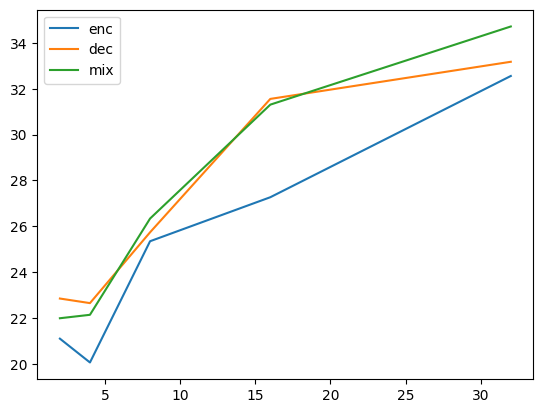

In [50]:
plt.plot([2, 4, 8, 16, 32], enc_accuracy_diff_size, label='enc')
plt.plot([2, 4, 8, 16, 32], dec_accuracy_diff_size, label='dec')
plt.plot([2, 4, 8, 16, 32], mix_accuracy_diff_size, label='mix')
plt.legend()

## Experiments

In [30]:
def train_model_ft(train_loader, model, criterion, optimizer, model_vae, optimizer_vae, activations, epochs=1000, loss_list=[], device='cuda'):
    if activations == 'encoder':
        activations = activations_encoder
    elif activations == 'decoder':
        activations = activations_decoder

    model.train()
    model_vae.train()
    loss_list = []
    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            # print(images.shape)
#             with torch.no_grad():
            loss_vae,_,_ = model_vae(images)
            # print(activations_decoder['layer1'].shape)
            if activations != 'mix':
                features_enc = transform_to_features(activations, labels.shape[0])
            else:
                features_enc = transform_to_features(activations_encoder, labels.shape[0])
                features_dec = transform_to_features(activations_decoder, labels.shape[0])
                features_enc = torch.cat((features_enc, features_dec), dim=1)

            # print(features_enc)
            features_enc = features_enc.to(device)
            outputs = model(features_enc)
            optimizer.zero_grad()

            loss = criterion(outputs, labels) + loss_vae
            loss.backward()
            optimizer.step()
            optimizer_vae.step()

            running_loss += loss.item()
        loss_list.append(running_loss / len(train_loader))
#         print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")
    return loss_list

In [33]:
num_classes = 100

train_indices = split(train_dataset, num_train_per_class=1)

train_subset = Subset(train_dataset, train_indices)
train_sub_loader = DataLoader(train_subset, batch_size=64, shuffle=True)


linModel = Net(num_all_features, num_classes).to(accelerator.device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(linModel.parameters(), lr=0.001)

accelerator = Accelerator()
model_vae = Model()
optimizer_vae = optim.Adam(model_vae.parameters(),lr=1e-3)
model_vae.load_state_dict(torch.load('./vq_vae_model.pt', map_location=torch.device(accelerator.device)))
model_vae,train_sub_loader,test_loader = accelerator.prepare(model,train_sub_loader,test_loader)

train_model_ft(train_sub_loader, linModel, criterion, optimizer, model_vae, optimizer_vae, activations='mix');

100%|██████████| 1000/1000 [00:41<00:00, 24.17it/s]


In [34]:
test_model(linModel, test_loader, model, activations='mix', device=accelerator.device)

Accuracy: 3.34%


3.34

## Resnet

In [16]:
import torchvision

In [27]:
def epoch_train(loader, clf, criterion, opt):
    clf.train(True)
    N, total_accuracy, total_loss = 0, 0, 0
    for images, labels in loader:
        images, labels = images.to(accelerator.device), labels.to(accelerator.device)
        output = clf(images)
        loss = criterion(output, labels)
        opt.zero_grad()
        loss.backward()
        opt.step()
        _, predicted = torch.max(output, 1)
        total_accuracy += (predicted == labels).sum().item()
        total_loss += loss.item()
        N += len(labels)
    return total_loss/len(loader), total_accuracy/N


def epoch_test(loader, clf, criterion):
    clf.eval()
    N, total_accuracy, total_loss = 0, 0, 0
    for images, labels in loader:
        images, labels = images.to(accelerator.device), labels.to(accelerator.device)
        output = clf(images)
        loss = criterion(output, labels)
        _, predicted = torch.max(output, 1)
        total_accuracy += (predicted == labels).sum().item()
        total_loss += loss.item()
        N += len(labels)
    return total_loss/len(loader), total_accuracy/N


def train_resnet(train_loader, test_loader, clf, criterion, opt, n_epochs=15):
    for epoch in tqdm(range(n_epochs)):
        train_loss, train_acc = epoch_train(train_loader, clf, criterion, opt)
        test_loss, test_acc = epoch_test(test_loader, clf, criterion)

        print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; train acc: {train_acc:.2f}; ' +
              f'test loss: {test_loss:.3f}; test acc: {test_acc:.2f}')

In [ ]:
train_indices = split(train_dataset, num_train_per_class=1)

train_subset = Subset(train_dataset, train_indices)
train_sub_loader = DataLoader(train_subset, batch_size=32, shuffle=True)

clf = torchvision.models.resnet18(num_classes=100).to(accelerator.device)
opt = optim.Adam(clf.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
clf,train_sub_loader,test_loader, opt, criterion = accelerator.prepare(clf,train_sub_loader,test_loader, opt, criterion)

train_resnet(train_sub_loader, test_loader, clf, criterion, opt)

In [29]:
from IPython.display import clear_output

resnet_acc = []
num_classes = 100
for train_size in [2, 4, 8, 16, 32, 64, 128, 256]:
    train_indices = split(train_dataset, num_train_per_class=train_size)

    train_subset = Subset(train_dataset, train_indices)
    train_sub_loader = DataLoader(train_subset, batch_size=32, shuffle=True)

    clf = torchvision.models.resnet18(num_classes=num_classes).to(accelerator.device)
    opt = optim.Adam(clf.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    clf,train_sub_loader,test_loader, opt, criterion = accelerator.prepare(clf,train_sub_loader,test_loader, opt, criterion)

    train_resnet(train_sub_loader, test_loader, clf, criterion, opt)
    resnet_acc.append(epoch_test(test_loader, clf, criterion)[1])
    clear_output(wait=True)
    print(resnet_acc)

[0.0343, 0.0486, 0.075, 0.1103, 0.154, 0.2219, 0.2884, 0.3704]


## VQModel

In [54]:
def train_vqvae(model, dataloader, optimizer, criterion,  epochs, accelerator):
    model = model.to(accelerator.device)
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for data, _ in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            
            inputs = data.to(accelerator.device)
            
            optimizer.zero_grad()
            outputs, vq_loss = model(inputs)
            
            reconstruction_loss = criterion(outputs, inputs)
            loss = reconstruction_loss + vq_loss
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_loss = running_loss / len(dataloader)
        
        test_iter = iter(test_loader)
        cur_iter = next(test_iter)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
        print('True:')
        imshow(utils.make_grid(cur_iter[0][:4].cpu(), nrow=4))       
        print('Reconstruct:')
        imshow(utils.make_grid(model(cur_iter[0][:4]).sample.detach().cpu(), nrow=4))

    print("Training complete")
    return model

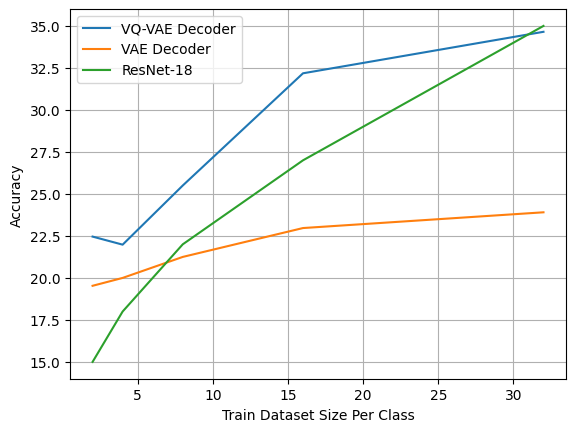

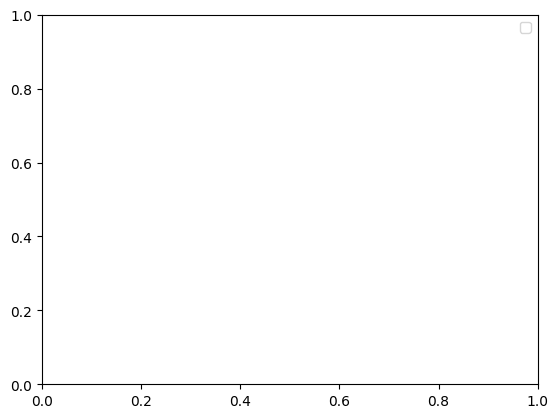

In [33]:
import matplotlib.pyplot as plt
import numpy as np


# CIFAR-10
data_size = np.array([2, 4, 8, 16, 32, 64, 128, 256]) 

enc_arr = [20.53, 18.43, 23.11, 26.9, 31.19, 33.16, 38.2, 42.73]
dec_arr = [22.46, 21.98, 25.5, 32.18, 34.65, 36.56, 41.17, 45.33]
mix_arr = [22.5, 21.52, 25.74, 31.14, 35.53, 37.6, 41.76, 45.32]

vae_dec = np.array([0.1953125, 0.2000000, 0.2125000, 0.2296875, 0.2390625, 0.2296875, 0.2640625, 0.2796875]) * 100
resnet_arr = np.array([0.15, 0.18, 0.22, 0.27, 0.35, 0.4, 0.46, 0.59])*100

# plt.plot(data_size, enc_arr, label='VQ-VAE Encoder')
l = 5
plt.plot(data_size[:l], dec_arr[:l], label='VQ-VAE Decoder')
plt.plot(data_size[:l], vae_dec[:l], label='VAE Decoder')
# plt.plot(data_size, mix_arr, label='VQ-VAE All')
plt.plot(data_size[:l], resnet_arr[:l], label='ResNet-18')

plt.ylabel('Accuracy')
plt.xlabel('Train Dataset Size Per Class')
plt.grid()
plt.legend()
plt.legend()
plt.show()


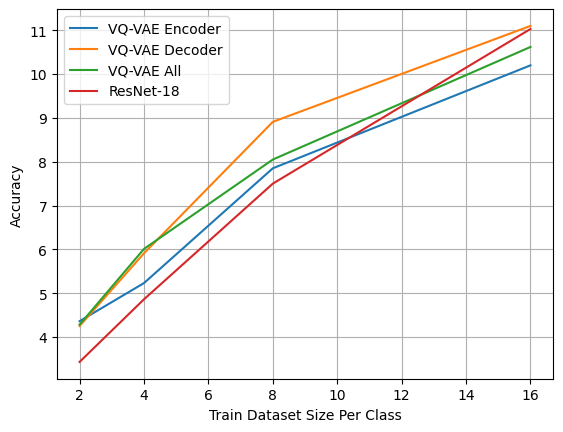

In [28]:
data_size = np.array([2, 4, 8, 16, 32, 64, 128, 256])

enc_arr = [4.36, 5.23, 7.85, 10.2, 13.23, 16.55, 19.35, 21.95]
dec_arr = [4.25, 5.91, 8.91, 11.1, 15.58, 18.84, 22.49, 24.37]
mix_arr = [4.28, 6.01, 8.05, 10.62, 14.88, 16.9, 19.96, 24.66]
resnet_arr = np.array([0.0343, 0.0486, 0.075, 0.1103, 0.154, 0.2219, 0.2884, 0.3704]) * 100

plt.plot(data_size[:4], enc_arr[:4], label='VQ-VAE Encoder')
plt.plot(data_size[:4], dec_arr[:4], label='VQ-VAE Decoder')
plt.plot(data_size[:4], mix_arr[:4], label='VQ-VAE All')
plt.plot(data_size[:4], resnet_arr[:4], label='ResNet-18')
# plt.xscale('log')
# plt.yscale('log')
plt.ylabel('Accuracy')
plt.xlabel('Train Dataset Size Per Class')
plt.grid()
plt.legend()
plt.show()